In [138]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import yfinance as yf

from pandas_datareader import data as pdr
yf.pdr_override()
import bisect

import math
from scipy.stats import gaussian_kde
from scipy.integrate import quad

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'http://127.0.0.1:25510/list/roots?sec=STOCK'
headers = {'Accept': 'application/json'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    # The request was successful
    json_data = response.json()
    print(json_data)
else:
    # Request failed
    print(f"Request failed with status code {response.status_code}")
    print(response.text)

{'header': {'id': 3, 'latency_ms': 4132, 'error_type': 'null', 'error_msg': 'null', 'next_page': 'null', 'format': None}, 'response': ['A', 'AA', 'AAA', 'AAAP', 'AAAU', 'AABA', 'AAC', 'AAC.U', 'AAC.WS', 'AACC', 'AACG', 'AACI', 'AACIU', 'AACIW', 'AACOU', 'AACOW', 'AACQ', 'AACQU', 'AACQW', 'AACT', 'AACT.U', 'AACT.WS', 'AADI', 'AADR', 'AAGR', 'AAGRW', 'AAIC', 'AAIC.PR.B', 'AAIC.PR.C', 'AAIN', 'AAIR', 'AAIT', 'AAL', 'AALCP', 'AAM.PR.A', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPB', 'AAPC', 'AAPD', 'AAPH', 'AAPL', 'AAPU', 'AAPX', 'AAPY', 'AAQC', 'AAQC.U', 'AAQC.WS', 'AAT', 'AATC', 'AAU', 'AAVL', 'AAWW', 'AAXJ', 'AAXN', 'AB', 'ABAC', 'ABAT', 'ABAX', 'ABB', 'ABBB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABCL', 'ABCM', 'ABCO', 'ABCS', 'ABCW', 'ABDC', 'ABEO', 'ABEOW', 'ABEQ', 'ABEV', 'ABFS', 'ABG', 'ABGB', 'ABGI', 'ABHD', 'ABIL', 'ABILW', 'ABIO', 'ABL', 'ABLLL', 'ABLLW', 'ABLV', 'ABLVW', 'ABLX', 'ABM', 'ABMD', 'ABNB', 'ABOS', 'ABR', 'ABR.PR.E', 'ABSI', 'ABST', 'ABT', 'ABTL', 'ABTS', 'ABTX', 'A

In [3]:
from enum import Enum

class Security(Enum):
    OPTION = 'option'
    EQUITY = 'stock'
    
class Req(Enum):
    TRADE = 'trade'
    QUOTE = 'quote'
    OI = 'open_interest'

class Right(Enum):
    CALL = 'C'
    PUT = 'P'

In [4]:
class ThetaDataAPI:
    def __init__(self):
        self.base_url = 'http://127.0.0.1:25510/'

    def _get_req(self, url: str, headers: dict, params: dict=None):
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Request failed with status code {response.status_code}")
            print(response.text)

    def get_roots(self, security_type: Security=Security.OPTION):
        url = f'{self.base_url}list/roots?sec={security_type.value}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

    def get_expirations(self, root:str):
        url = f'{self.base_url}list/expirations?root={root}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_strikes(self, root: str, exp: str):
        url = f'{self.base_url}list/strikes?root={root}&exp={exp}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_dates(self, root: str, security_type: Security=Security.OPTION, exp: str=None, strike_right: tuple[str, Right]=None):
        url = f'{self.base_url}list/dates/{security_type.value}/quote'
        url_params = {}
        url_params["root"] = root
        if exp is not None:
            url_params["exp"] = exp
        if strike_right is not None:
            url_params["strike"] = strike_right[0]
            url_params["right"] = strike_right[1].value
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers, params=url_params)
    
    """
    NOTE this function has a 750ms overhead 
    """
    def get_contracts(self, date: str, req: Req=Req.TRADE):
        url = f'{self.base_url}list/contracts/option/{req.value}?start_date={date}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
        
    def get_eod_prices(self, root: str, security_type: Security, start_date: str, end_date: str, exp: str=None, strike: str=None, right: Right=None):
        url = None
        if security_type == Security.EQUITY:
            url = f'{self.base_url}hist/{security_type.value}/eod?root={root}&start_date={start_date}&end_date={end_date}'
        elif security_type == Security.OPTION:
            url = f'{self.base_url}hist/{security_type.value}/eod?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}'
        headers = {'Accept': 'application/json'}
        print(url)
        return self._get_req(url=url, headers=headers)

    def get_hist_quotes(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str=None):
        url = f'{self.base_url}hist/option/quote?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={0 if ivl is None else ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

    def get_ohlc(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/ohlc?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_oi(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/open_interest?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_trades(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right):
        url = f'{self.base_url}hist/option/trade?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

    def get_hist_trade_quotes(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right):
        url = f'{self.base_url}hist/option/trade_quote?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_iv(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/implied_volatility?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_iv_verbose(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/implied_volatility_verbose?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_eod_greeks(self, root: str, exp: str, start_date: str, end_date: str):
        url = f'{self.base_url}bulk_hist/option/eod_trade_greeks?root={root}&exp={exp}&start_date={start_date}&end_date={end_date}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

client = ThetaDataAPI()

In [32]:
class WrapperClient:
    def __init__(self):
        self.thetadata = ThetaDataAPI()
        self.date_format = "%Y%m%d"

    def get_dates_in_range(self, root: str, exp: str, start_date: str, end_date: str):
        dates = self.thetadata.get_dates(root=root, exp=exp)["response"]
        start = start_date if start_date is not None else dates[0]
        end = end_date if end_date is not None else dates[len(dates)-1]
        start_datetime = dt.strptime(str(start), self.date_format)
        end_datetime = dt.strptime(str(end), self.date_format)
        dates = [date for date in dates if start_datetime <= dt.strptime(str(date), self.date_format) <= end_datetime]
        return (start, end, dates)
    
    # return eod data about an underlying over some range of time
    def get_underlying_over_time(self, root: str, security_type: Security, points: list[str], dates: list[str]):
        num_days = len(dates)
        data = {}
        for point in points:
            data[point] = [None] * num_days
        data_points = {}
        for i in range(num_days):
            eod_prices = self.thetadata.get_eod_prices(root=root, security_type=security_type, start_date=dates[i], end_date=dates[i])
            header = eod_prices["header"]
            response = eod_prices["response"]
            # initialize data_points based on format
            if not data_points:
                for point in points:
                    data_points[point] = header["format"].index(point)
            for point, index in data_points.items():
                data[point][i] = response[0][index]
        return data

    # return interval NBBO of a chain over some range of time
    def get_chain_over_time(self, root: str, exp: str, strike: str, right: Right, start_date: str, end_date: str, ivl: int=3600000):
        """
        Gets interval NBBO of a chain over some range of time.

        Returns:
        pd.Dataframe with columns ["date", "ms_of_day", "bid", "ask"]
        """
        ret = []
        data = self.thetadata.get_hist_quotes(root=root, start_date=start_date, end_date=end_date, exp=exp, strike=strike, right=right, ivl=ivl)
        format = data["header"]["format"]
        response = data["response"]
        ask_ind = format.index("ask")
        bid_ind = format.index("bid")
        date_ind = format.index("date")
        timestamp_ind = format.index("ms_of_day")
        for row in response:
            ret.append([row[date_ind], row[timestamp_ind], row[bid_ind], row[ask_ind]])
        return pd.DataFrame(ret, columns=["date", "ms_of_day", "bid", "ask"])

    # garbage function for testing
    def test_get_chain_over_time(self, root: str, exp: str, strike: str, right: Right, dates: list[str]):
        prices = []
        for date in dates:
            data = self.thetadata.get_hist_trades(root=root, start_date=date, end_date=date, exp=exp, strike=strike, right=right)
            header = data["header"]
            if header["error_type"] != "null":
                print(strike, date)
                #print(data)
                continue
            ind = header["format"].index("price")
            prices.append(data["response"][-1][ind])
        print(prices)
        
    # deprecated
    def get_chains_over_time(self, root: str, exp: str, right: Right, points: list[str], start_date: str=None, end_date: str=None):
        start, end, dates = self.get_dates_in_range(root=root, exp=exp, start_date=start_date, end_date=end_date)
        num_days = len(dates)
        strikes = self.thetadata.get_strikes(root=root, exp=exp)["response"]
        num_strikes = len(strikes)
        data = {}
        for point in points:
            data[point] = []
        data_points = {}
        valid_strikes = []
        for i in range(num_strikes):
            eod_prices = self.thetadata.get_hist_quotes(root=root, start_date=start, end_date=end, exp=exp, strike=strikes[i], right=right)
            header = eod_prices["header"]
            # skip if there was error with data
            if header["error_type"] != "null":
                continue
            response = eod_prices["response"]
            if not data_points:
                for point in points:
                    data_points[point] = header["format"].index(point)
            for point, index in data_points.items():
                data[point].append([d[index] for d in response])
        for point in points:
            data[point] = np.column_stack(data[point])
        print(data)
        return (dates, valid_strikes, data)


    # Need to address blanks in data
    def get_greeks_chains_over_time(self, root: str, exp: str, points: list[str], start_date: str=None, end_date: str=None):
        start, end, dates = self.get_dates_in_range(root=root, exp=exp, start_date=start_date, end_date=end_date)
        num_days = len(dates)
        eod_greeks = cached_eod_greeks #self.thetadata.get_eod_greeks(root=root, start_date=start, end_date=end, exp=exp)
        header = eod_greeks["header"]
        response = eod_greeks["response"]
        data_points = {}
        calls = {}
        puts = {}
        for point in points:
            data_points[point] = header["format"].index(point)
            calls[point] = {}
            puts[point] = {}
        for eod in response:
            contract = eod["contract"]
            ticks = eod["ticks"]
            for point, index in data_points.items():
                (calls if contract["right"] == "C" else puts)[point][contract["strike"]] = [d[index] for d in ticks]
        for point in points:
            print(list(calls[point].values()))
            # calls[point] = {k: v for k, v in calls[point].items() if len(v)==num_days}
            # calls[point] = (calls[point].keys(), np.column_stack(list(calls[point].values())))
        return (calls, puts)

wrapper_client = WrapperClient()

0.006250551925273976


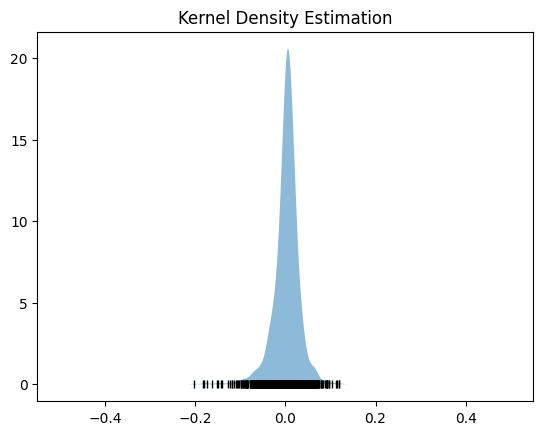

0.008286427728546842


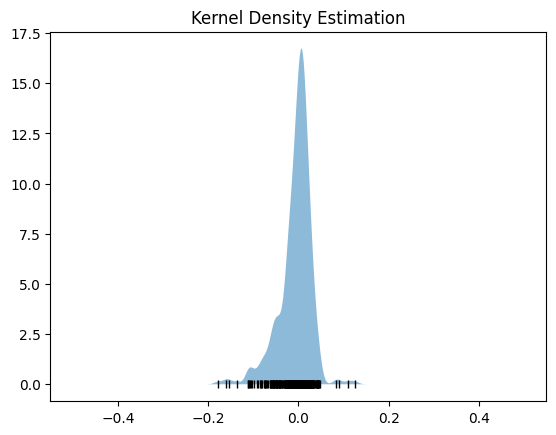

0.019306977288832496


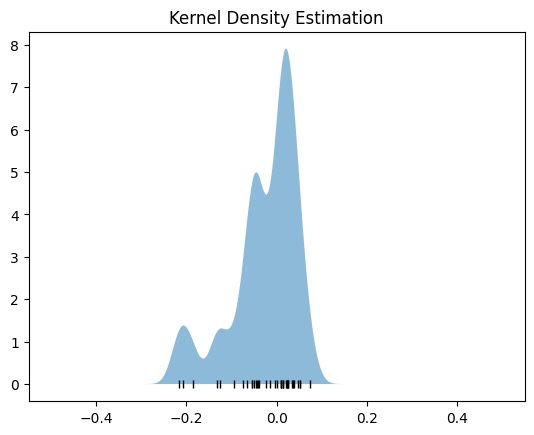

In [194]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KernelDensity

class Model:
    def __init__(self, root: str, start_date: dt.date):
        """
        Initializes KDE model for options pricing

        Arguments:
        root: ticker for security
        start_date: lookback period for model
        """
        price = pdr.get_data_yahoo([root], start_date, dt.date.today(), progress=False)['Adj Close']
        daily_returns = np.log(price/price.shift(1))
        daily_returns_sanitized = [x for x in daily_returns.values if x is not None and math.isfinite(x)]
        grid = GridSearchCV(estimator=KernelDensity(kernel = 'gaussian'), param_grid={'bandwidth': np.logspace(-3, 0, 50)}, cv=TimeSeriesSplit(n_splits=5))
        """
        daily_returns_reshaped = np.array([x for x in daily_returns.values if x is not None and math.isfinite(x)]).reshape(-1, 1)
        grid.fit(daily_returns_reshaped)
        test_kde = grid.best_estimator_
        print(test_kde.bandwidth_)
        test_kde_scipy = gaussian_kde(dataset=daily_returns_sanitized, bw_method=test_kde.bandwidth_ / np.std(daily_returns_sanitized, ddof=1)*(len(daily_returns_sanitized)**(-1/5)))
        print(test_kde_scipy.factor)
        self.base_kde = test_kde_scipy
        """
        vix_parametrized_returns = self.vix_parametrize(returns=daily_returns, offset=1)
        self.kde = [None for _ in range(6)]
        for regime in range(4):
            if len(vix_parametrized_returns[regime]) >= 30:
                daily_returns_reshaped = np.array(vix_parametrized_returns[regime]).reshape(-1, 1)
                grid.fit(daily_returns_reshaped)
                print(grid.best_estimator_.bandwidth_)
                self.kde[regime] = grid.best_estimator_ #gaussian_kde(dataset=vix_parametrized_returns[regime], bw_method=grid.best_estimator_.bandwidth_ / np.std(vix_parametrized_returns[regime], ddof=1)*(len(vix_parametrized_returns[regime])**(-1/5)))
                x_d = np.linspace(-0.5, 0.5, 1000).reshape(-1, 1)
                log_dens = self.kde[regime].score_samples(x_d)
                plt.fill_between(x_d[:, 0], np.exp(log_dens), alpha=0.5)
                plt.plot(daily_returns_reshaped[:, 0], np.full_like(daily_returns_reshaped, -0.01), '|k', markeredgewidth=1)
                plt.title('Kernel Density Estimation')
                plt.show()
                """
                x_d = np.linspace(-0.25, 0.25, 1000)
                plt.plot(x_d, self.kde[regime](x_d), color='k', label='KDE')
                plt.title('Kernel Density Estimation SciPy')
                plt.show()
                """

    def vix_parametrize(self, returns: pd.Series, offset: int):
        """
        Arguments:
        data: time series of log returns
        offset: time scale of returns (in days)

        Returns:
        returns bucketed into VIX regimes (0-8, 8-16, 16-24, 24-32, 32-40, >40)
        """
        start_date = returns.index[0]
        vix = pdr.get_data_yahoo(['^VIX'], start_date, dt.date.today(), progress=False)['Adj Close']
        vix_parametrized_returns = [[] for _ in range(4)]
        for i in range(offset, returns.size):
            if returns[i] is not None and math.isfinite(returns[i]) and abs(returns[i])<=0.25: vix_parametrized_returns[min(int((vix[i]-8)//16)+1, 3)].append(returns[i])
        return vix_parametrized_returns

    def generate_kde(self, data):
        kde = gaussian_kde(dataset=data, bw_method='silverman')
        print(f"KDE bandwidth: {kde.factor * np.std(data, ddof=1)}")
        return kde
    
    def call_pdf_creator(self, kde: KernelDensity, strike: float, spot: float):
        """
        Generates PDF to price call option given a KDE representing the returns over next time period
        """
        def pdf(x):
            return math.exp(kde.score_samples(np.array([[x]]))[0]) * max(0, spot * math.exp(x) - strike)
        return pdf
    
    def put_pdf_creator(self, kde: KernelDensity, strike: float, spot: float):
        """
        Generates PDF to price put option given a KDE representing the returns over next time period
        """
        def pdf(x):
            return math.exp(kde.score_samples(np.array([[x]]))[0]) * max(0, strike - spot * math.exp(x))
        return pdf
    
    def call_theo(self, strike: float, spot: float, spot_vix: float, show_plot: bool) -> float:
        """
        Integrates PDF to get call option theo
        """
        pdf = self.call_pdf_creator(kde=self.kde[min(int((spot_vix-8)//16)+1, 3)], strike=strike, spot=spot)
        result, error = quad(pdf, -1, 1)
        if error > 1e-3:
            print(f"WARNING (call): error on integration {error} > 1e-3")
        if show_plot:
            x_d = np.linspace(-0.25, 0.25, 1000)
            y_d = [pdf(x) for x in x_d]
            plt.plot(x_d, y_d, color='k', label='KDE')
            plt.title('Call Theo PDF')
            plt.show()
        return result
    
    def put_theo(self, strike: float, spot: float, spot_vix: float, show_plot: bool):
        """
        Integrates PDF to get pdf option theo
        """
        pdf = self.put_pdf_creator(kde=self.kde[min(int((spot_vix-8)//16)+1, 3)], strike=strike, spot=spot)
        result, error = quad(pdf, -1, 1)
        if error > 1e-3:
            print(f"WARNING (put): error on integration {error} > 1e-3")
        if show_plot:
            x_d = np.linspace(-0.25, 0.25, 1000)
            y_d = [pdf(x) for x in x_d]
            plt.plot(x_d, y_d, color='k', label='KDE')
            plt.title('Put Theo PDF')
            plt.show()
        return result

    # returns 1 for long, 0 for no signal, -1 for short
    def signal(self, strike: float, spot: float, bid: float, ask: float, right: Right, spot_vix: float, verbose: bool=False, show_plot: bool=False):
        """
        Run the model to determine if there's a signal.

        Returns:
        +1 for long
        0 for no signal
        -1 for short
        """
        if verbose: print(f"strike: {strike}, spot: {spot}, vix: {spot_vix}")
        if right == Right.CALL:
            theo = self.call_theo(strike=strike, spot=spot, spot_vix=spot_vix, show_plot=show_plot)
            if verbose: print(f"theo (call): {theo}, bid: {bid}, ask: {ask}")
            return int(theo > ask) - int(theo < bid)
        else:
            theo = self.put_theo(strike=strike, spot=spot, spot_vix=spot_vix, show_plot=show_plot)
            if verbose: print(f"theo (put): {theo}, bid: {bid}, ask: {ask}")
            return int(theo > ask) - int(theo < bid)
        
svxy_model = Model(root="SVXY", start_date=dt.date(2013, 1, 1))
#svxy_model.signal(strike=48, spot=47.7400016784668, bid=0.25, ask=0.65, right=Right.CALL, spot_vix=16)
#svxy_model.signal(strike=48, spot=47.7400016784668, bid=0.25, ask=0.65, right=Right.PUT, spot_vix=16)

In [170]:
class Engine:
    def __init__(self, root: str, start_date: dt.date):
        self.calls_long = 0
        self.calls_long_pnl = 0
        self.calls_short = 0
        self.calls_short_pnl = 0
        self.puts_long = 0
        self.puts_long_pnl = 0
        self.puts_short = 0
        self.puts_short_pnl = 0
        self.trades = []
        self.spot_price = pdr.get_data_yahoo([root], start_date, dt.date.today(), progress=False)['Adj Close']

    def pnl_option_to_expiry(self, entry: float, strike: float, exp: dt.date, right: Right, direction: int):
        """
        Update backtest PnL with new option held-to-expiry trade
        """
        self.trades.append([right.value, direction, entry, strike, self.spot_price[exp.strftime('%Y-%m-%d')]])
        if right==right.CALL:
            if direction==1:
                self.calls_long += 1
                self.calls_long_pnl += max(self.spot_price[exp.strftime("%Y-%m-%d")] - strike, 0) - entry
            else:
                self.calls_short += 1
                self.calls_short_pnl += entry - max(self.spot_price[exp.strftime("%Y-%m-%d")] - strike, 0)
        else:
            if direction==1:
                self.puts_long += 1
                self.puts_long_pnl += max(strike - self.spot_price[exp.strftime("%Y-%m-%d")], 0) - entry
            else:
                self.puts_short += 1
                self.puts_short_pnl += entry - max(strike - self.spot_price[exp.strftime("%Y-%m-%d")], 0)

    def print_pnl(self):
        print(f"calls long: {self.calls_long}, calls long PnL: {self.calls_long_pnl}")
        print(f"calls short: {self.calls_short}, calls short PnL: {self.calls_short_pnl}")
        print(f"puts long: {self.puts_long}, puts long PnL: {self.puts_long_pnl}")
        print(f"puts short: {self.puts_short}, puts short PnL: {self.puts_short_pnl}")
    
    def get_trades(self):
        return pd.DataFrame(self.trades, columns=["Right", "Direction", "Entry", "Strike", "Spot at Expiry"])

In [196]:
# backtesting framework - SVIX and SVXY
flag = False
svix_expirations = client.get_expirations(root="SVIX")["response"][-280:-250]
svxy_expirations = client.get_expirations(root="SVXY")["response"][-280:-80]
print(svix_expirations, svxy_expirations)
#svix_model = Model("SVIX", dt.date(2000, 1, 1))
#svxy_model = Model("SVXY", dt.date(2000, 1, 1))
engine = Engine("SVXY", dt.date(2000, 1, 1))

svxy_start_dates = []
for exp in svxy_expirations: # last trade on previous day (1 day before expiration)
    # get previous day
    exp_datetime = dt.datetime.strptime(str(exp), "%Y%m%d")
    start_date_datetime = exp_datetime - timedelta(days=1)
    start_date = int(start_date_datetime.strftime("%Y%m%d"))
    svxy_start_dates.append(start_date)

for exp, start_date in zip(svxy_expirations, svxy_start_dates):
    strikes = client.get_strikes(root="SVXY", exp=exp)["response"]

    start_date_datetime = dt.datetime.strptime(str(start_date), "%Y%m%d")
    start_year = start_date_datetime.year
    start_month = start_date_datetime.month
    start_day = start_date_datetime.day

    exp_datetime = dt.datetime.strptime(str(exp), "%Y%m%d")
    exp_year = exp_datetime.year
    exp_month = exp_datetime.month
    exp_day = exp_datetime.day

    svxy = pdr.get_data_yahoo(["SVXY"], dt.date(start_year, start_month, start_day), dt.date(exp_year, exp_month, exp_day), progress=False)['Adj Close']
    vix = pdr.get_data_yahoo(["^VIX"], dt.date(start_year, start_month, start_day), dt.date(exp_year, exp_month, exp_day), progress=False)['Adj Close']
    if svxy.size == 0 or vix.size == 0:
        continue

    spot_price = svxy.iloc[0]
    spot_vix = vix.iloc[0]
    index = bisect.bisect_left(strikes, spot_price * 1000)
    try:
        strike_price = strikes[index]
    except:
        strike_price = strikes[index - 1]
    K = strike_price / 1000

    try:
        chain_call = wrapper_client.get_chain_over_time(root="SVXY", exp=exp, strike=strike_price, right=Right.CALL, ivl=3600000, start_date=start_date, end_date=start_date)
        chain_put = wrapper_client.get_chain_over_time(root="SVXY", exp=exp, strike=strike_price, right=Right.PUT, ivl=3600000, start_date=start_date, end_date=start_date)
    except:
        continue
    
    last_call = chain_call.iloc[-1]
    last_put = chain_put.iloc[-1]

    call_signal = svxy_model.signal(strike=K, spot=spot_price, bid=last_call["bid"], ask=last_call["ask"], right=Right.CALL, spot_vix=spot_vix)
    put_signal = svxy_model.signal(strike=K, spot=spot_price, bid=last_put["bid"], ask=last_put["ask"], right=Right.PUT, spot_vix=spot_vix)
    if flag: print(f"SVXY {exp} {strike_price} {call_signal} {put_signal}")
    if call_signal == 1:
        engine.pnl_option_to_expiry(entry=last_call["ask"], strike=K, exp=exp_datetime, right=Right.CALL, direction=1)
    elif call_signal == -1:
        engine.pnl_option_to_expiry(entry=last_call["bid"], strike=K, exp=exp_datetime, right=Right.CALL, direction=-1)
    if put_signal == 1:
        engine.pnl_option_to_expiry(entry=last_put["ask"], strike=K, exp=exp_datetime, right=Right.PUT, direction=1)
    elif put_signal == -1:
        engine.pnl_option_to_expiry(entry=last_put["bid"], strike=K, exp=exp_datetime, right=Right.PUT, direction=-1)

engine.print_pnl()
engine.get_trades()


[] [20220520, 20220527, 20220603, 20220610, 20220617, 20220624, 20220701, 20220708, 20220715, 20220722, 20220729, 20220805, 20220812, 20220819, 20220826, 20220902, 20220909, 20220916, 20220923, 20220930]
strike: 48.0, spot: 47.7400016784668, vix: 29.350000381469727
theo (call): 0.35899688559825393, bid: 0.25, ask: 0.65
strike: 48.0, spot: 47.7400016784668, vix: 29.350000381469727
theo (put): 0.8799627195375035, bid: 0.55, ask: 1.25
strike: 49.0, spot: 48.599998474121094, vix: 27.5
theo (call): 0.3120025480067446, bid: 0.1, ask: 0.35
strike: 49.0, spot: 48.599998474121094, vix: 27.5
theo (put): 0.9776727010078343, bid: 0.35, ask: 0.7
strike: 51.0, spot: 50.709999084472656, vix: 24.719999313354492
theo (call): 0.37557925548864085, bid: 0.15, ask: 0.4
strike: 51.0, spot: 50.709999084472656, vix: 24.719999313354492
theo (put): 0.942782974672487, bid: 0.3, ask: 0.7
strike: 50.5, spot: 50.209999084472656, vix: 26.09000015258789
theo (call): 0.3706945228229209, bid: 0.2, ask: 0.45
strike: 50.

,Right,Direction,Entry,Strike,Spot at Expiry
0,P,1,0.70,49.0,49.580002
1,P,1,0.70,51.0,50.450001
2,P,1,0.70,50.5,48.660000
3,C,1,0.45,48.0,48.410000
4,C,1,0.25,48.5,48.770000
5,P,1,0.60,48.5,48.770000
6,P,1,0.50,49.5,50.020000
7,C,1,0.30,49.5,50.610001
8,P,1,0.55,49.5,50.610001
9,C,1,0.25,51.5,51.630001


In [ ]:
"""
Base KDE (Scott's Rule) stats
calls long: 135, calls long PnL: -5.760001220703127
calls short: 12, calls short PnL: 4.309998321533203
puts long: 73, puts long PnL: -14.620008850097655
puts short: 17, puts short PnL: -0.11999900817871012
"""

"""
VIX parametrized KDE (Scott's Rule) stats
calls long: 154, calls long PnL: -4.389995117187501
calls short: 6, calls short PnL: 2.51999755859375
puts long: 105, puts long PnL: -26.77999534606934
puts short: 8, puts short PnL: 1.1500010681152344
"""

In [26]:
dates = wrapper_client.get_dates_in_range(root="AAPL", exp=20220930, start_date=20220910, end_date=20220928)[2]
strikes = [135000, 140000, 145000] #client.get_strikes(root="AAPL", exp=20220930)["response"]
for K in strikes:
    # print(wrapper_client.get_chain_over_time(root="AAPL", exp=20220930, strike=K, right=Right.CALL, dates=dates))
    print(wrapper_client.get_chain_over_time(root="AAPL", exp=20220930, strike=K, right=Right.CALL, ivl=3600000, start_date=20220910, end_date=20220928))

        date  ms_of_day    bid    ask
0   20220912   36000000  26.90  27.00
1   20220912   39600000  26.70  26.80
2   20220912   43200000  27.20  27.30
3   20220912   46800000  28.40  28.50
4   20220912   50400000  29.45  29.50
..       ...        ...    ...    ...
86  20220928   43200000  12.50  12.55
87  20220928   46800000  12.85  12.95
88  20220928   50400000  12.50  12.60
89  20220928   54000000  13.90  13.95
90  20220928   57600000  14.75  15.05

[91 rows x 4 columns]
        date  ms_of_day    bid    ask
0   20220912   36000000  22.05  22.15
1   20220912   39600000  21.80  21.90
2   20220912   43200000  22.30  22.40
3   20220912   46800000  23.50  23.60
4   20220912   50400000  24.55  24.60
..       ...        ...    ...    ...
86  20220928   43200000   7.75   7.85
87  20220928   46800000   8.10   8.15
88  20220928   50400000   7.75   7.85
89  20220928   54000000   9.05   9.15
90  20220928   57600000   9.95  10.20

[91 rows x 4 columns]
        date  ms_of_day    bid    ask
0   

In [27]:
print(wrapper_client.get_chain_over_time(root="SVXY", exp=20230317, strike=55000, right=Right.CALL, ivl=3600000, start_date=20230117, end_date=20230317))
print(wrapper_client.get_chain_over_time(root="SVXY", exp=20230317, strike=55000, right=Right.PUT, ivl=3600000, start_date=20230117, end_date=20230317))
print(client.get_expirations(root="SVXY"))

,date,ms_of_day,bid,ask
0,20230117,36000000,9.00,9.70
1,20230117,39600000,8.50,9.50
2,20230117,43200000,9.20,9.80
3,20230117,46800000,9.40,10.20
4,20230117,50400000,9.50,9.90
...,...,...,...,...
296,20230317,43200000,3.10,3.40
297,20230317,46800000,3.10,3.30
298,20230317,50400000,3.10,3.50
299,20230317,54000000,2.60,2.85


In [37]:
eod = client.get_eod_prices(root=root, start_date=20230301, end_date=20230406, exp=20230406, strike=150000, right=Right.CALL, security_type=Security.OPTION)
eod

http://127.0.0.1:25510/hist/option/eod?root=AAPL&start_date=20230301&end_date=20230406&strike=150000&exp=20230406&right=C


{'header': {'id': 35,
  'latency_ms': 466,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['open', 'high', 'low', 'close', 'volume', 'count', 'date']},
 'response': [[3.95, 3.95, 3.13, 3.2, 319, 55, 20230301],
  [2.8, 3.5, 2.59, 3.3, 484, 67, 20230302],
  [4.05, 5.6, 3.75, 5.6, 1079, 217, 20230303],
  [7.33, 9.05, 7.0, 7.3, 752, 135, 20230306],
  [7.22, 7.35, 5.6, 5.9, 294, 65, 20230307],
  [6.6, 6.95, 6.2, 6.5, 274, 53, 20230308],
  [6.8, 7.55, 5.35, 5.4, 197, 52, 20230309],
  [5.05, 5.4, 4.01, 4.26, 430, 135, 20230310],
  [4.4, 6.7, 4.16, 5.3, 463, 136, 20230313],
  [5.86, 6.5, 4.88, 5.76, 1547, 160, 20230314],
  [5.55, 6.7, 4.98, 6.32, 301, 73, 20230315],
  [6.2, 8.5, 6.0, 8.15, 176, 54, 20230316],
  [7.75, 8.71, 7.4, 7.7, 79, 37, 20230317],
  [7.7, 9.45, 7.55, 9.23, 62, 40, 20230320],
  [9.71, 10.48, 8.56, 10.43, 88, 36, 20230321],
  [10.85, 12.44, 9.73, 9.73, 145, 58, 20230322],
  [10.3, 12.1, 9.56, 10.37, 83, 37, 20230323],
  [10.07, 10.9, 9.4, 

In [38]:
quotes = client.get_hist_quotes(root=root, start_date=20230331, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL, ivl=60000)
quotes

{'header': {'id': 36,
  'latency_ms': 48,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'bid_size',
   'bid_condition',
   'bid',
   'bid_exchange',
   'ask_size',
   'ask_condition',
   'ask',
   'ask_exchange',
   'date']},
 'response': [[34200000, 0, 1, 0.0, 50, 0, 1, 0.0, 50, 20230331],
  [34260000, 90, 11, 12.5, 50, 90, 11, 12.9, 50, 20230331],
  [34320000, 90, 11, 12.5, 50, 90, 11, 12.9, 50, 20230331],
  [34380000, 90, 11, 12.5, 50, 90, 11, 12.8, 50, 20230331],
  [34440000, 90, 11, 12.8, 50, 90, 11, 13.05, 50, 20230331],
  [34500000, 90, 11, 13.05, 50, 90, 11, 13.35, 50, 20230331],
  [34560000, 91, 11, 12.9, 50, 90, 11, 13.15, 50, 20230331],
  [34620000, 90, 11, 12.95, 50, 90, 11, 13.2, 50, 20230331],
  [34680000, 90, 11, 12.9, 50, 92, 11, 13.2, 50, 20230331],
  [34740000, 39, 11, 12.95, 50, 93, 11, 13.15, 50, 20230331],
  [34800000, 39, 11, 12.8, 50, 90, 11, 13.0, 50, 20230331],
  [34860000, 90, 11, 12.95, 50, 39, 11, 13.15, 5

In [39]:
ohlc = client.get_ohlc(root=root, start_date=20230331, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL, ivl=900000)
ohlc

{'header': {'id': 37,
  'latency_ms': 29,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'open',
   'high',
   'low',
   'close',
   'volume',
   'count',
   'date']},
 'response': [[34200000, 0.0, 0.0, 0.0, 0.0, 0, 0, 20230331],
  [35100000, 12.77, 12.77, 12.64, 12.64, 2, 2, 20230331],
  [36000000, 12.78, 12.98, 12.78, 12.85, 4, 4, 20230331],
  [36900000, 12.85, 12.85, 12.5, 12.5, 9, 6, 20230331],
  [37800000, 12.73, 12.76, 12.73, 12.73, 22, 4, 20230331],
  [38700000, 12.95, 13.15, 12.95, 13.08, 104, 3, 20230331],
  [39600000, 13.13, 13.13, 12.95, 12.95, 3, 3, 20230331],
  [40500000, 0.0, 0.0, 0.0, 0.0, 0, 0, 20230331],
  [41400000, 13.05, 13.05, 13.05, 13.05, 10, 1, 20230331],
  [42300000, 0.0, 0.0, 0.0, 0.0, 0, 0, 20230331],
  [43200000, 13.35, 13.35, 13.35, 13.35, 11, 2, 20230331],
  [44100000, 13.41, 13.5, 13.41, 13.49, 9, 4, 20230331],
  [45000000, 13.6, 14.03, 13.6, 14.03, 27, 8, 20230331],
  [45900000, 14.07, 14.09, 13.8, 14.0

In [40]:
oi = client.get_hist_oi(root=root, start_date=20230301, end_date=20230401, exp=20230406, strike=150000, right=Right.CALL, ivl=900000)
oi

{'header': {'id': 38,
  'latency_ms': 964,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['open_interest', 'date']},
 'response': [[207, 20230301],
  [325, 20230302],
  [716, 20230303],
  [1426, 20230306],
  [1406, 20230307],
  [1474, 20230308],
  [1549, 20230309],
  [1546, 20230310],
  [1640, 20230313],
  [1646, 20230314],
  [1834, 20230315],
  [1835, 20230316],
  [1779, 20230317],
  [1790, 20230320],
  [1781, 20230321],
  [1789, 20230322],
  [1791, 20230323],
  [1791, 20230324],
  [1785, 20230327],
  [1752, 20230328],
  [1784, 20230329],
  [1868, 20230330],
  [1886, 20230331]]}

In [46]:
trades = client.get_hist_trades(root=root, start_date=20230301, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL)
trades

{'header': {'id': 44,
  'latency_ms': 0,
  'error_type': 'DISCONNECTED',
  'error_msg': 'Connection lost to Theta Data MDDS.',
  'next_page': 'null',
  'format': None},
 'response': [0]}

In [42]:
quotes = client.get_hist_quotes(root=root, start_date=20230331, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL)
quotes

{'header': {'id': 40,
  'latency_ms': 64,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'bid_size',
   'bid_condition',
   'bid',
   'bid_exchange',
   'ask_size',
   'ask_condition',
   'ask',
   'ask_exchange',
   'date']},
 'response': [[28800211, 0, 60, 0.0, 50, 0, 60, 0.0, 50, 20230331],
  [28800257, 0, 42, 0.0, 50, 0, 42, 0.0, 50, 20230331],
  [28800326, 0, 65, 0.0, 50, 0, 65, 0.0, 50, 20230331],
  [28801788, 0, 5, 0.0, 50, 0, 5, 0.0, 50, 20230331],
  [30600163, 0, 65, 0.0, 50, 0, 65, 0.0, 50, 20230331],
  [30600195, 0, 42, 0.0, 50, 0, 42, 0.0, 50, 20230331],
  [30600196, 0, 60, 0.0, 50, 0, 60, 0.0, 50, 20230331],
  [30601668, 0, 5, 0.0, 50, 0, 5, 0.0, 50, 20230331],
  [32400090, 0, 60, 0.0, 50, 0, 60, 0.0, 50, 20230331],
  [32400126, 0, 42, 0.0, 50, 0, 42, 0.0, 50, 20230331],
  [32400253, 0, 5, 0.0, 50, 0, 5, 0.0, 50, 20230331],
  [32400340, 0, 65, 0.0, 50, 0, 65, 0.0, 50, 20230331],
  [33900204, 0, 31, 0.0, 50, 0, 31, 0.0, 50

In [44]:
iv = client.get_hist_iv(root=root, start_date=20230301, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL, ivl=3600000)
iv

{'header': {'id': 42,
  'latency_ms': 21011,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'bid',
   'bid_implied_vol',
   'midpoint',
   'implied_vol',
   'ask',
   'ask_implied_vol',
   'underlying_price',
   'date']},
 'response': [[36000000,
   3.5,
   0.2478,
   3.9,
   0.2701,
   4.3,
   0.292,
   146.92,
   20230301],
  [39600000, 3.65, 0.2671, 3.7, 0.2699, 3.75, 0.2725, 146.47, 20230301],
  [43200000, 3.65, 0.2672, 3.67, 0.2687, 3.7, 0.2703, 146.45, 20230301],
  [46800000, 3.6, 0.2664, 3.62, 0.2674, 3.65, 0.2691, 146.38, 20230301],
  [50400000, 3.4, 0.267, 3.42, 0.2682, 3.45, 0.27, 145.87, 20230301],
  [54000000, 3.25, 0.2677, 3.27, 0.2693, 3.3, 0.2702, 145.48, 20230301],
  [57600000, 3.15, 0.2653, 3.35, 0.2768, 3.55, 0.2882, 145.32, 20230301],
  [36000000, 2.74, 0.2669, 2.76, 0.2681, 2.78, 0.2693, 144.34, 20230302],
  [39600000, 2.75, 0.2643, 2.76, 0.2649, 2.78, 0.2661, 144.48, 20230302],
  [43200000, 2.69, 0.2635, 2.71, 0.2

In [ ]:
eod_greeks = client.get_eod_greeks(root=root, exp=20230406, start_date=20230329, end_date=20230331)
eod_greeks